# Heart Disease: Categorical ML Modeling

## 1. Project Overview:
The purpose of this project is to use categorical multiple machine learning models to solve a business problem.

My chosen problem is to see if I can predict heart disease from a variety of general factors. The business problem in this case is for a web application where, with just a few questions, an individual or their doctor could screen for the possibility that they have heart disease. 

In [4]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, f1_score, make_scorer, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
import xgboost
from xgboost import XGBClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, ADASYN
import random
from random import randint
from sklearn.datasets import *
from IPython.display import Image, display_svg, SVG
import os
from dtreeviz.trees import *
from sklearn.tree import plot_tree
os.environ["PATH"] += os.pathsep + "C:\\Users\\tmcro\\anaconda3\\pkgs\\graphviz-2.38-hfd603c8_2\\Library\\bin\\graphviz\\"


### B) The Data

This project utilizes a dataset from kaggle: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

This dataset come from the CDC and is a major part of the Behavioral Risk Factor Surveillance System (BRFSS), which conducts annual telephone surveys to gather data on the health status of U.S. residents.

According to the CDC:
'Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.'

In [5]:
# Load Data
df = pd.read_csv('heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## Define Target Variable

In this case, the target variable is whether or not an individual had heart disease. 

In [6]:
target = ['HeartDisease']

## Define Scoring Metric
For the purposes of this analysis, I think a custom scoring metric is necessary. 

My reasoning is this:
- False negatives could cause patients with heart disease to not recieve further testing. This would be the worst possibility, out of the options. 
- False positives would cost more due to testing people who did not actually have heart disease, or could cause people without heart disease to needlessly worry about their health. This is also costly, but not as costly as missing an individual with heart disease. 

Thus, I want to minimize false negatives while keeping false positives to an appropriate level. The F1-score is a geometric average of recall and precision. I will make a recall-weighted F-score by adding a 2x weight to the recall (or false negatives) in this equation. 


In [7]:
def my_custom_score(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
    return rwf_score

my_scorer = make_scorer(my_custom_score, greater_is_better= True)

# Change class metric
class_metric = my_scorer

## Describe Data

The data contains 18 variables and approximately 320,000 observations. 

The variables in the dataset include:
- 1. HeartDisease - Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)
- 2. Smoking (Question: Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes])
- 3. AlcoholDrinking (Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)
- 4. Stroke - Has the individual had a stroke?
- 5. PhysicalHealth -ORDINAL Categorical Variable - (Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days)
- 6. MentalHealth - ORDINAL Categorical Variable - (Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days))
- 7. DiffWalking (Do you have serious difficulty walking or climbing stairs?)
- 8. Sex - Male or Female
- 9. AgeCategory - ORDINAL Categorical Variable (Fourteen-level age category)
- 10. Race
- 11. Diabetic - Yes/No/Borderline
- 12. PhysicalActivity - Adults who reported doing physical activity or exercise during the past 30 days other than their regular job
- 13. GenHealth - Is the individuals general health good / fair/ poor / very good / great?
- 14. Asthma - Yes/No
- 15. KidneyDisease - Yes/No
- 16. SkinCancer - Yes/No
- 17. SleepTime - How many hours per night do you sleep (Continuous Variable)
- 18. BMI - What is your body mass index

In [8]:
# Describe Data
df.describe().round(2)

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.00,319795.00,319795.00,319795.00
mean,28.33,3.37,3.90,7.10
std,6.36,7.95,7.96,1.44
min,12.02,0.00,0.00,1.00
25%,24.03,0.00,0.00,6.00
50%,27.34,0.00,0.00,7.00
75%,31.42,2.00,3.00,8.00
max,94.85,30.00,30.00,24.00


#### Check for missing values

In [9]:
nothere = df.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
nothere

,0


#### Check Dtypes

In [10]:
df.dtypes

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

#### Set visuals

In [11]:
# Set visual parameters for plots
plt.rcParams.update({'font.family':'Open Sans'})
plt.rcParams['figure.figsize'] = (7,5)
sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

# Primary Colors
bluez = '#417396'
redz = '#802b37'

#### Check Distributions

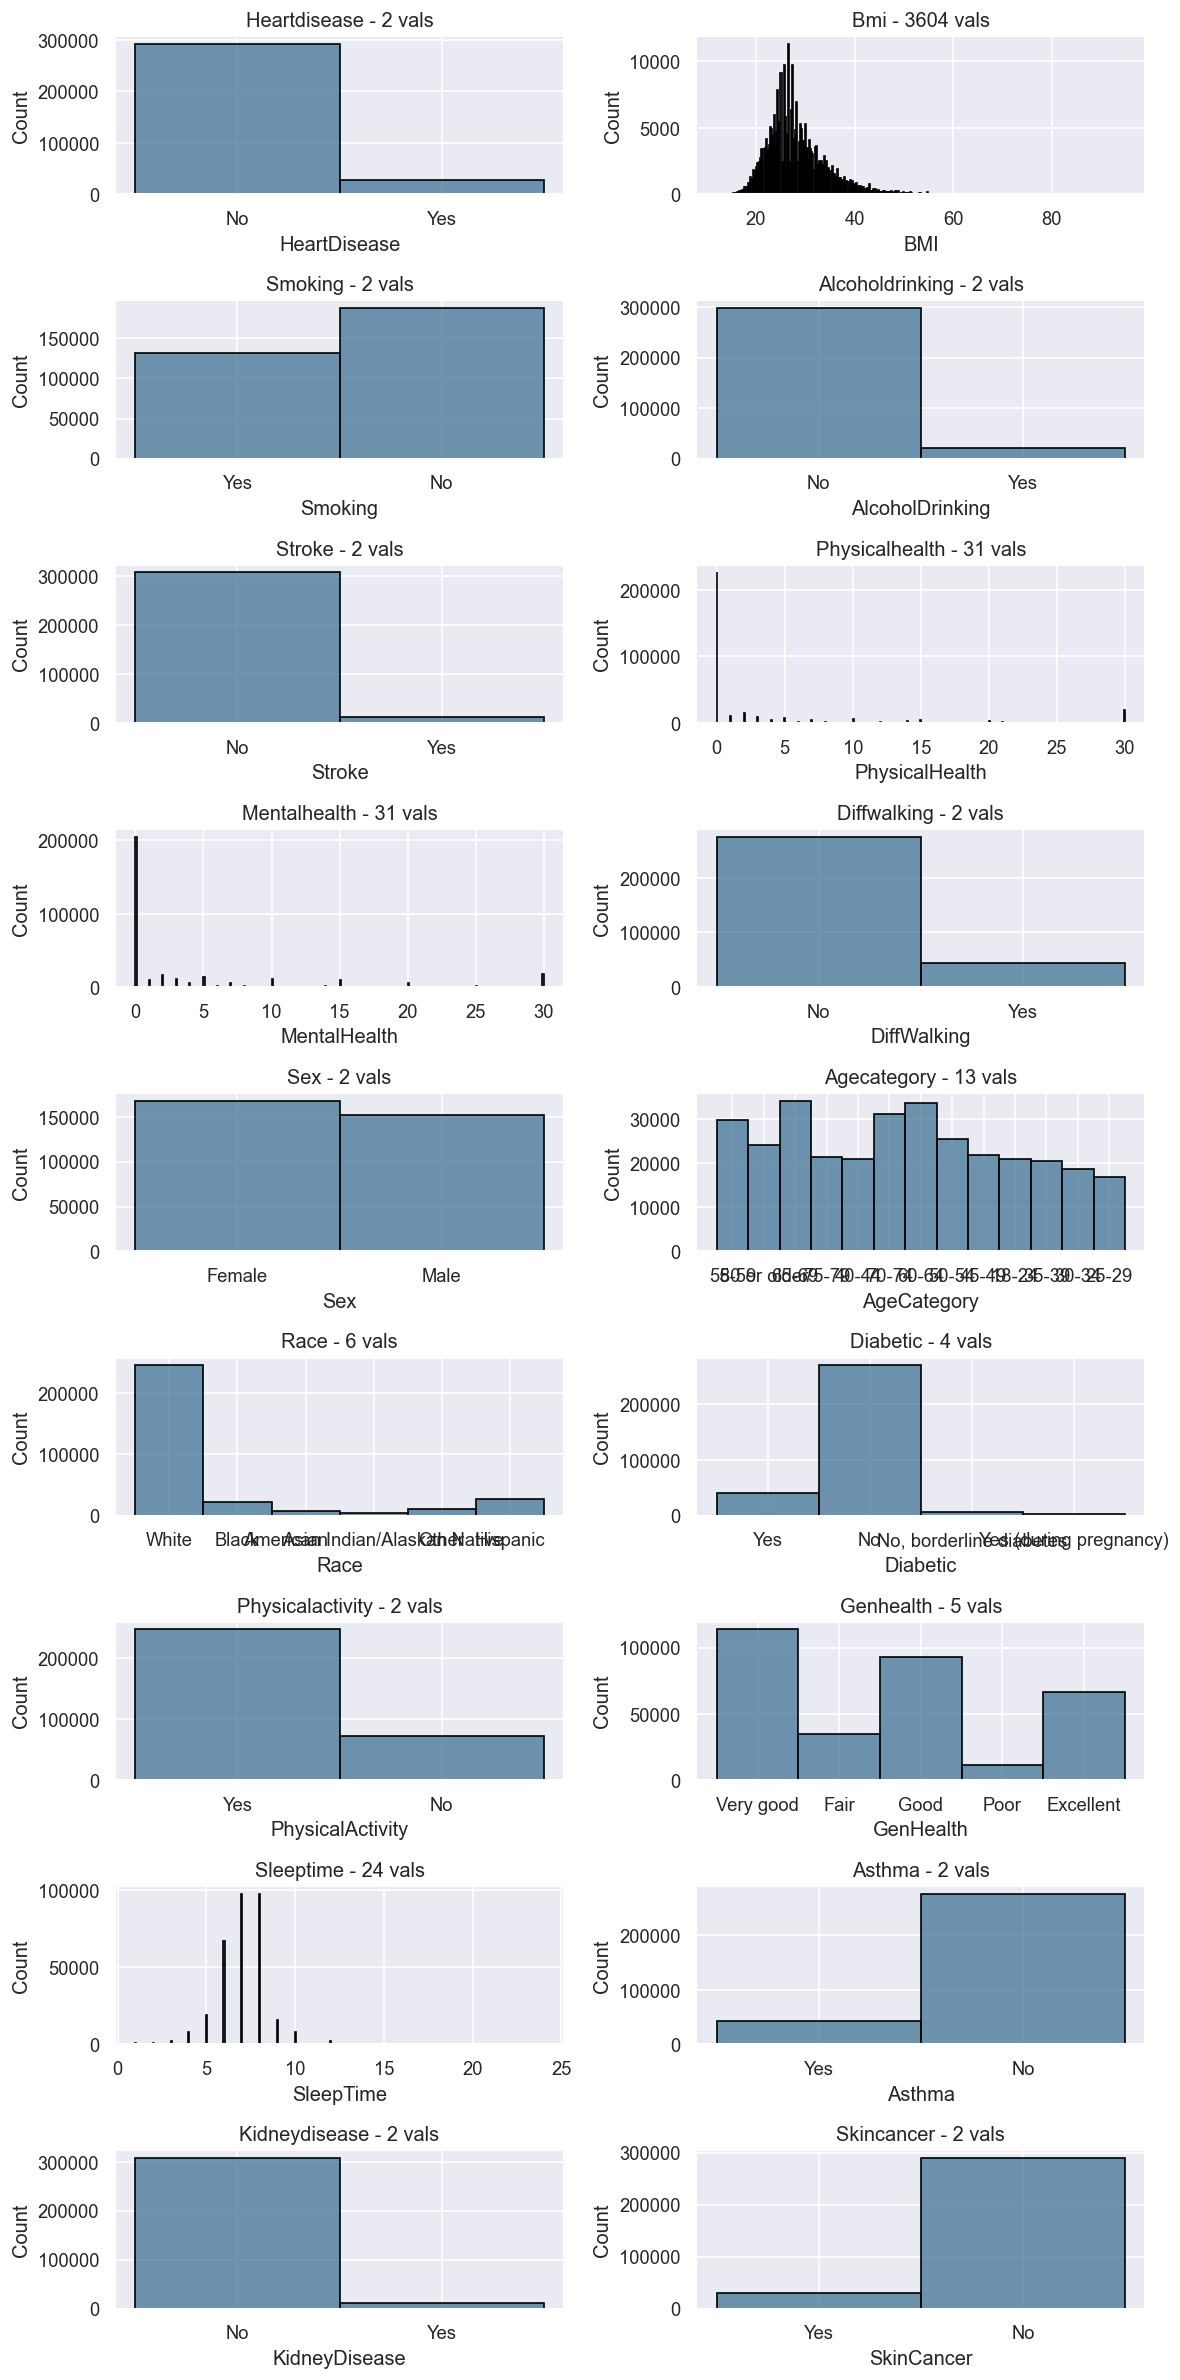

In [12]:
# Check the Variable's Distributions
num = len(df.columns)/2
plt.figure(figsize = (10,20), dpi = 120)
sns.set(font_scale = 1)

for n, column in enumerate(df.columns, 1):
    plt.subplot(int(num),2,n)
    sns.histplot(df[column], color='#417396', edgecolor="black", linewidth=1)
    plt.tight_layout()
    col = str.capitalize(column)
    lu = df[column].nunique(dropna= True)
    plt.title(f'{col} - {lu} vals', fontsize = 12)
    #plt.suptitle(f'{lu} Unique Values', fontsize = 10)
    plt.plot()

#### Identify Variable Types

In [13]:
ordinal = ["AgeCategory", "PhysicalHealth", "MentalHealth", "GenHealth"]
continuous = ['BMI', 'SleepTime']
to_drop= ordinal+ continuous + target
#to_drop = to_drop.append('HeartDisease')
categorical1 = df.drop(columns = to_drop)
categorical = list(categorical1.columns)

### Change Yes/No to 1/0

In [14]:
yes_no_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
                'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

In [15]:
for colz in yes_no_cols:
    df[colz] = np.where(df[colz] == "Yes", 1, 0)

In [16]:
df[target] = np.where(df[target] == "Yes", 1, 0)

## Check for Class Imbalance

In [17]:
df.HeartDisease.value_counts()

0    292422
1     27373
Name: HeartDisease, dtype: int64

In [18]:
no_hd = len(df.loc[df['HeartDisease'] == 0])
hd = len(df.loc[df['HeartDisease'] == 1])

In [19]:
no_hd2 = no_hd / (no_hd + hd)
no_hd2

0.9144045404086993

In [20]:
hd2 = hd / (hd+no_hd)
hd2

0.08559545959130067

In [21]:
df.BMI

0         16.60
1         20.34
2         26.58
3         24.21
4         23.71
          ...  
319790    27.41
319791    29.84
319792    24.24
319793    32.81
319794    46.56
Name: BMI, Length: 319795, dtype: float64

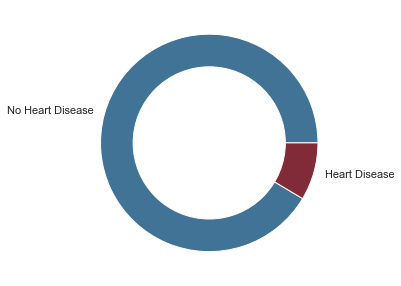

In [22]:
names = ['No Heart Disease', 'Heart Disease']
size = [no_hd, hd]

my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=[bluez, redz])
p = plt.gcf()
p.gca().add_artist(my_circle)


## Data Splitting

In [23]:
# Split the outcome and predictor variables
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

In [24]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, random_state=120)

## Variable Processing

### A) Seperate by Data Type

In [25]:
X_train_ord = X_train[ordinal]
X_test_ord = X_test[ordinal]
X_train_cat = X_train[categorical]
X_test_cat = X_test[categorical]
X_train_cont = X_train[continuous]
X_test_cont = X_test[continuous]

ord_shape = X_train_ord.shape
cat_shape = X_train_cat.shape
cont_shape = X_train_cont.shape

print(f' ordinal shape is {ord_shape}')
print(f' categorical shape is {cat_shape}')
print(f' continuous shape is {cont_shape}')


 ordinal shape is (239846, 4)
 categorical shape is (239846, 11)
 continuous shape is (239846, 2)


In [26]:
ord_cols = list(X_train_ord.columns)
cat_cols = list(X_train_cat.columns)
cont_cols = list(X_train_cont.columns)

### B) Standardize Continuous Data

In [27]:
ss = StandardScaler()
X_train_cont_scaled = ss.fit_transform(X_train_cont)
X_test_cont_scaled = ss.transform(X_test_cont)

In [28]:
X_train_cont_df = pd.DataFrame(X_train_cont_scaled, columns = cont_cols)
X_test_cont_df = pd.DataFrame(X_test_cont_scaled, columns = cont_cols)
X_train_cont_df


,BMI,SleepTime
0,-0.294135,0.630476
1,-0.460959,-0.764522
2,0.300766,0.630476
3,-0.388564,0.630476
4,-0.737950,-0.067023
...,...,...
239841,-0.070654,4.117970
239842,-0.944119,0.630476
239843,-0.265807,-0.067023
239844,0.017480,1.327974


### C) Encode Ordinal Data

In [29]:
ord_encode = OrdinalEncoder(categories=[['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'],
                                        ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21','22', '23', '24', '25', '26', '27', '28', '29', '30' ],
                                        ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21','22', '23', '24', '25', '26', '27', '28', '29', '30' ],
                                        ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']])

X_train_ord_encoded = ord_encode.fit_transform(X_train_ord[['AgeCategory', 'PhysicalHealth', 'MentalHealth', 'GenHealth']])
X_test_ord_encoded = ord_encode.transform(X_test_ord[['AgeCategory', 'PhysicalHealth', 'MentalHealth', 'GenHealth']])

In [30]:
X_train_ord_df= pd.DataFrame(X_train_ord_encoded, columns = ord_cols)
X_test_ord_df= pd.DataFrame(X_test_ord_encoded, columns = ord_cols)
X_train_ord_df

,AgeCategory,PhysicalHealth,MentalHealth,GenHealth
0,9.0,2.0,5.0,1.0
1,7.0,18.0,30.0,1.0
2,8.0,0.0,7.0,3.0
3,2.0,0.0,0.0,4.0
4,7.0,0.0,15.0,3.0
...,...,...,...,...
239841,11.0,0.0,0.0,2.0
239842,2.0,0.0,0.0,4.0
239843,2.0,0.0,0.0,3.0
239844,11.0,0.0,0.0,3.0


### D) Encode Categorical Data

In [31]:
ohe = OneHotEncoder()
X_train_cat_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.transform(X_test_cat)

In [32]:
X_train_cat_encoded

<239846x28 sparse matrix of type '<class 'numpy.float64'>'
	with 2638306 stored elements in Compressed Sparse Row format>

### Combine variable types into DataFrame

In [33]:
columns = ohe.get_feature_names(input_features = X_train_cat.columns)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded.todense(), columns=columns)
X_Test_cat_df = pd.DataFrame(X_test_cat_encoded.todense(), columns=columns)
X_train_cat_df

,Smoking_0,Smoking_1,AlcoholDrinking_0,AlcoholDrinking_1,Stroke_0,Stroke_1,DiffWalking_0,DiffWalking_1,Sex_Female,Sex_Male,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_0,PhysicalActivity_1,Asthma_0,Asthma_1,KidneyDisease_0,KidneyDisease_1,SkinCancer_0,SkinCancer_1
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239841,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
239842,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
239843,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
239844,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [34]:
ord_n_cat_train = pd.concat([X_train_ord_df, X_train_cat_df], axis = 1)
ord_n_cat_test = pd.concat([X_test_ord_df, X_Test_cat_df], axis = 1)

In [35]:
X_all_train = pd.concat([ord_n_cat_train, X_train_cont_df], axis = 1)
X_all_test = pd.concat([ord_n_cat_test, X_test_cont_df], axis = 1)

### SMOTE

In [36]:
print(y_train.value_counts())
# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_all_train, y_train)
# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts())

0    219367
1     20479
Name: HeartDisease, dtype: int64


1    219367
0    219367
Name: HeartDisease, dtype: int64


## Fitting and Testing ML Models

### A) Code Additions

In [37]:
# 1. Confusion Matrix
# SOURCE: The origin of this confusion matrix code was found on medium, '
# from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\nRecall-Weighted F Score={:0.3f}".format(
                accuracy,precision,recall,f1_score, rwf_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title,size = 20)

In [38]:
# Define Result Saving Initial Function
def save_result(cf, model_name):
            accuracy  = np.trace(cf) / float(np.sum(cf))
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
            #Create results column
            results_columns = ['Model', 'RWF Score', 'F1', 'Recall', 'Precision', 'Accuracy']
            row = [(model_name, rwf_score, f1_score, recall, precision, accuracy)]
            model_summary = pd.DataFrame(columns = results_columns, data = row)
            return model_summary.round(3)

In [39]:
# Define Result Saving Function after initial

def update_results(cf, model_name):
    accuracy  = np.trace(cf) / float(np.sum(cf))
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
    model_summy = pd.read_excel('model_summary.xlsx')
    model_summy = pd.DataFrame(model_summy)
    results_columns = ['Model', 'RWF Score', 'F1', 'Recall', 'Precision', 'Accuracy']
    new_row = [(model_name, rwf_score, f1_score, recall, precision, accuracy)]
    model_summy2 = pd.DataFrame(columns = results_columns, data = new_row)
    model_s = model_summy.append(model_summy2)
    model_s = model_s.drop(columns = ['Unnamed: 0'])
    model_s.drop_duplicates(subset=['Model'], inplace = True)
    model_s = model_s.sort_values('RWF Score', ascending = False)
    model_s.to_excel('model_summary.xlsx')
    return model_s.round(3)


### B) Model Result Saving

## Model 1: Logistic Regression

In [40]:
# Initial Model
logreg_s = LogisticRegression(fit_intercept=False, solver='liblinear')
# Probability scores for test set
y_score_s = logreg_s.fit(X_train_resampled, y_train_resampled)

In [41]:
X_all_test.head(3)

,AgeCategory,PhysicalHealth,MentalHealth,GenHealth,Smoking_0,Smoking_1,AlcoholDrinking_0,AlcoholDrinking_1,Stroke_0,Stroke_1,...,PhysicalActivity_0,PhysicalActivity_1,Asthma_0,Asthma_1,KidneyDisease_0,KidneyDisease_1,SkinCancer_0,SkinCancer_1,BMI,SleepTime
0,2.0,0.0,15.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.413745,-1.462021
1,12.0,25.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.430763,0.630476
2,6.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,-1.746764,-0.067023


In [42]:
log_reg_pred = logreg_s.predict(X_all_test)
cm = classification_report(y_test,log_reg_pred)
cf_matrix = confusion_matrix(y_test, log_reg_pred)

In [43]:
model_summary = save_result(cf_matrix, 'Logistic Regression')
model_summary.to_excel('model_summary.xlsx')
model_summary

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.395,0.35,0.783,0.226,0.75


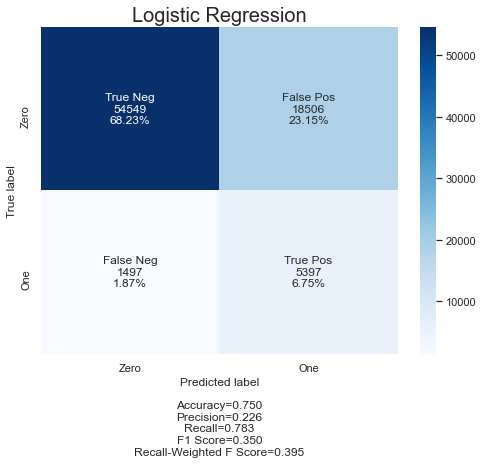

In [44]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues', title= "Logistic Regression",
                      figsize = (8,6))

### Iterate Logistic Regression with Random

In [45]:
y_score_s.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': False,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [46]:
y_score_s.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [47]:
params = {'max_iter': np.arange(50,150,50),
            'verbose': np.arange(0,1,1),
            'C': np.arange(1,5,1),
}

rand_LogReg = RandomizedSearchCV(logreg_s,param_distributions=params,n_jobs= -1, n_iter=25,scoring= class_metric)

rand_LogReg.fit(X_train_resampled, y_train_resampled)


RandomizedSearchCV(estimator=LogisticRegression(fit_intercept=False,
                                                solver='liblinear'),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'C': array([1, 2, 3, 4]),
                                        'max_iter': array([ 50, 100]),
                                        'verbose': array([0])},
                   scoring=make_scorer(my_custom_score))

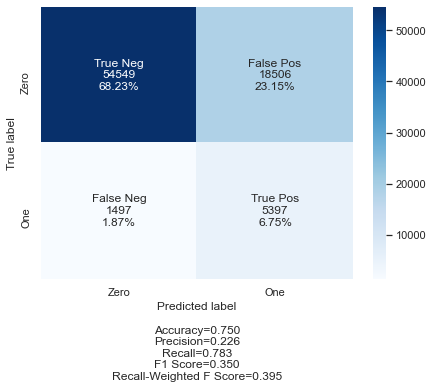

In [48]:
rand_logreg_pred = rand_LogReg.predict(X_all_test)
cf_matrix = confusion_matrix(y_test, rand_logreg_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [49]:
model_sum = update_results(cf_matrix, 'Logistic Regression - RandomizedSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.395,0.35,0.783,0.226,0.75
0,Logistic Regression - RandomizedSearch,0.395,0.35,0.783,0.226,0.75


## Decision Tree

In [50]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=5)

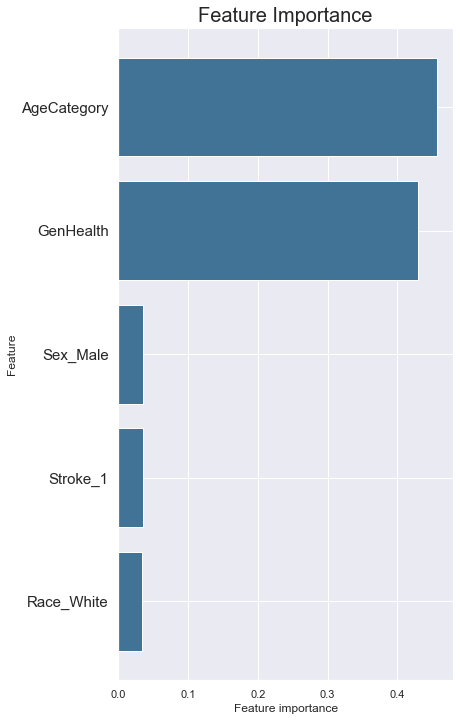

In [51]:
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    imp_df = pd.DataFrame(model.feature_importances_)
    nm_df = pd.DataFrame(X_train_resampled.columns.values) 
    imp_feats = pd.merge(nm_df, imp_df, left_index=True, right_index=True)
    imp_feats= imp_feats.round(3)
    imp_feats= imp_feats.rename(columns = {'0_x' : 'Feature', '0_y' : 'Importance' })
    imp_feats = imp_feats.loc[imp_feats['Importance'] > .01]
    imp_feats = imp_feats.sort_values('Importance', ascending = True)
    n_features = imp_feats.shape[0]
    plt.figure(figsize=(6, 12))
    
    plt.barh(range(n_features), imp_feats['Importance'], align='center', color = bluez) 
    plt.yticks(np.arange(n_features), imp_feats['Feature'].values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.yticks(size = 15 )
    plt.title('Feature Importance', fontsize = 20)

plot_feature_importances(tree_clf)

In [52]:
# Test set predictions
dec_tree_pred = tree_clf.predict(X_all_test)
cf_matrix = confusion_matrix(y_test, dec_tree_pred)

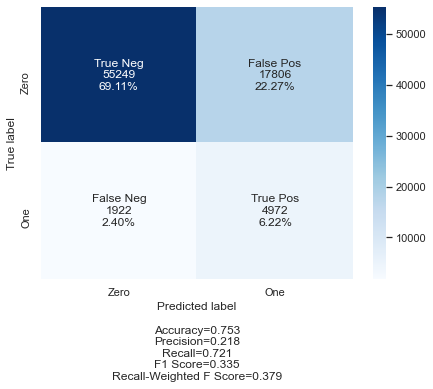

In [53]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [54]:
model_sum = update_results(cf_matrix, 'Decision Tree')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.395,0.350,0.783,0.226,0.750
1,Logistic Regression - RandomizedSearch,0.395,0.350,0.783,0.226,0.750
0,Decision Tree,0.379,0.335,0.721,0.218,0.753


AUC: 0.7387363368248866


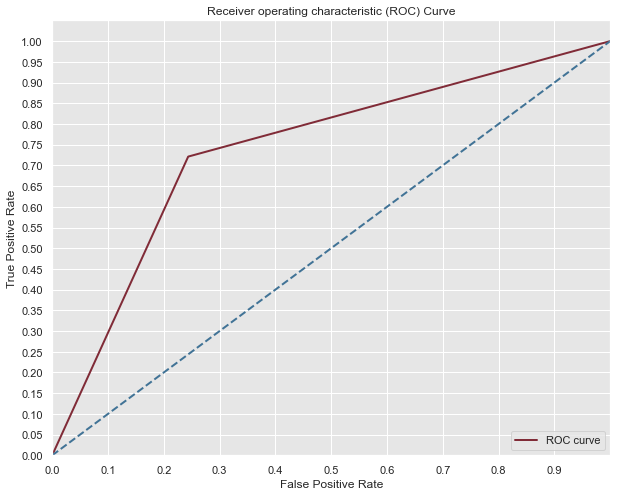

In [55]:
# Plot ROC
fpr, tpr, thresholds = roc_curve(y_test, dec_tree_pred)
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
print('AUC: {}'.format(auc(fpr, tpr)))                    # Print AUC
plt.figure(figsize=(10, 8))                               # Plot the ROC curve
lw = 2 
plt.plot(fpr, tpr, color=redz, 
            lw=lw, label='ROC curve') 
plt.plot([0, 1], [0, 1], color=bluez, lw=lw, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)]) 
plt.xticks([i/10.0 for i in range(10)])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right') 
plt.show()

In [ ]:
viz = dtreeviz(tree_clf, X_all_train, y, target_name='HeartDisease', 
                feature_names = X_all_train.columns, class_names =['No Heart Disease', 'Has Heart Disease'])

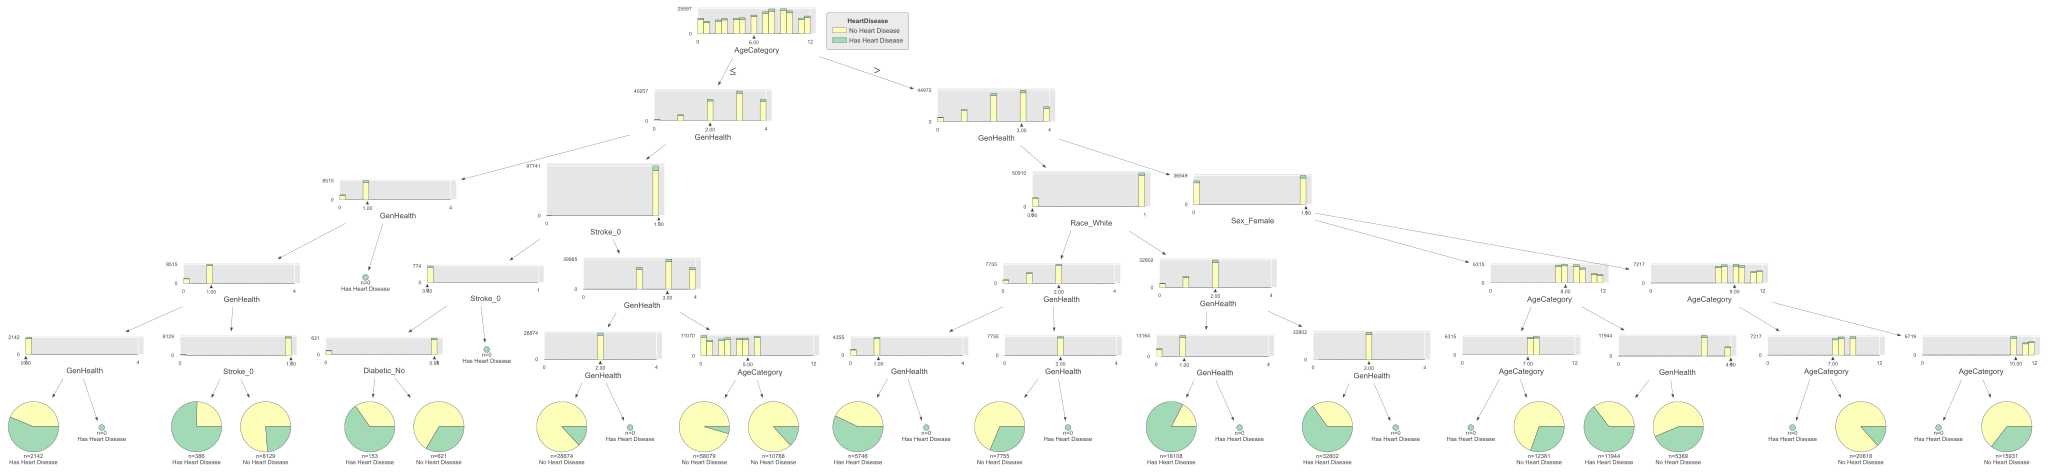

In [ ]:
viz

### RandomSearch

In [ ]:
tree_clf.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [ ]:
params = {'max_depth': np.arange(2,10,1),
           'min_samples_leaf': np.arange(0, 5, 1),
           'min_impurity_decrease': np.arange(0,2,.5),
           'ccp_alpha' : np.arange(0,3, 0.5),
           'criterion': ['gini', 'entropy']
}

rand_clf = RandomizedSearchCV(tree_clf,param_distributions=params, n_iter=25,scoring= class_metric)

rand_clf.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(estimator=DecisionTreeClassifier(max_depth=5), n_iter=25,
                   param_distributions={'ccp_alpha': array([0. , 0.5, 1. , 1.5, 2. , 2.5]),
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_impurity_decrease': array([0. , 0.5, 1. , 1.5]),
                                        'min_samples_leaf': array([0, 1, 2, 3, 4])},
                   scoring=make_scorer(my_custom_score))

In [ ]:
rand_clf.best_params_

{'min_samples_leaf': 3,
 'min_impurity_decrease': 0.0,
 'max_depth': 6,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

In [ ]:
dec_tree_randsearch_pred = rand_clf.predict(X_all_test)
cf_matrix = confusion_matrix(y_test, dec_tree_randsearch_pred)

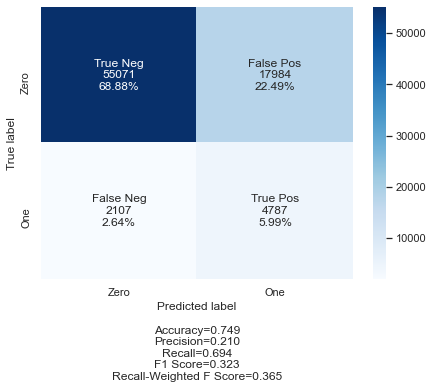

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Decision Tree -- Random Search')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Logistic Regression,0.395,0.350,0.782,0.226,0.750
1,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
2,Decision Tree,0.370,0.329,0.737,0.212,0.741
0,Decision Tree -- Random Search,0.365,0.323,0.694,0.210,0.749


## Random Forest Model

In [57]:
# fit a RandomForest
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5)

In [58]:
forest.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

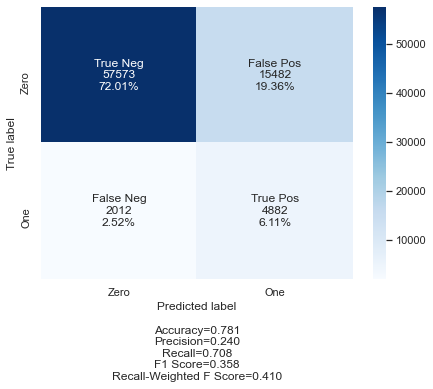

In [59]:

random_forest_pred = forest.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, random_forest_pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')


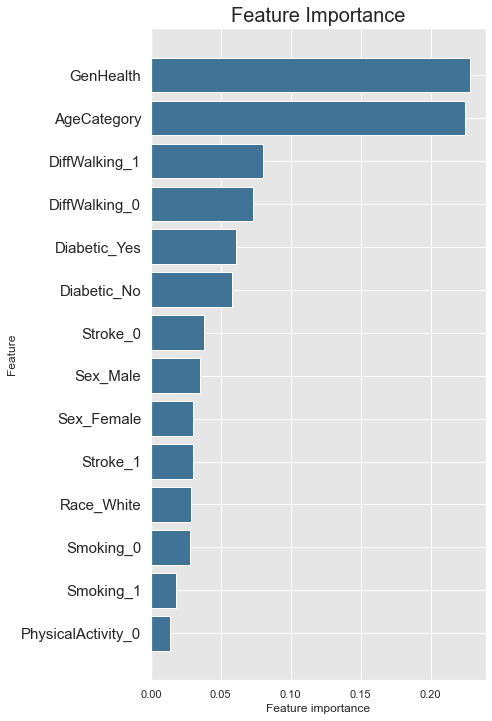

In [60]:
plot_feature_importances(forest)

In [61]:
model_sum = update_results(cf_matrix, 'Random Forest')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest,0.410,0.358,0.708,0.240,0.781
0,Logistic Regression,0.395,0.350,0.783,0.226,0.750
1,Logistic Regression - RandomizedSearch,0.395,0.350,0.783,0.226,0.750
2,Decision Tree,0.379,0.335,0.721,0.218,0.753


### GridSearchCV with Random Forest Model #1

In [62]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth' : [4,5,6],
}

In [ ]:
# 12 minute runtime
CV_rfc = GridSearchCV(forest, param_grid=param_grid, cv= 5, scoring= class_metric)
CV_rfc.fit(X_train_resampled, y_train_resampled)

In [ ]:
CV_rfc.best_params_

{'max_depth': 6, 'n_estimators': 100}

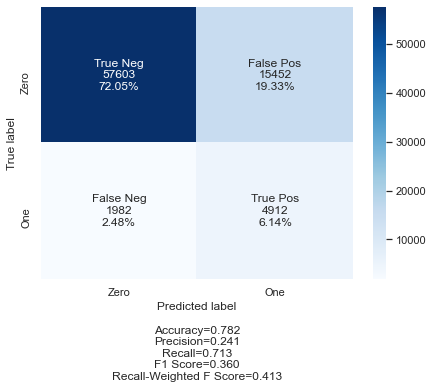

In [ ]:
rf_GridSearch_pred = CV_rfc.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, rf_GridSearch_pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Random Forest -- GridSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
0,Random Forest,0.410,0.359,0.724,0.239,0.777
1,Logistic Regression,0.395,0.350,0.782,0.226,0.750
2,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
3,Decision Tree,0.370,0.329,0.737,0.212,0.741
4,Decision Tree -- Random Search,0.365,0.323,0.694,0.210,0.749


## XGBOOST Model

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xgboost_preds = clf.predict(X_all_test)


In [ ]:
cf_matrix = confusion_matrix(y_test, xgboost_preds)

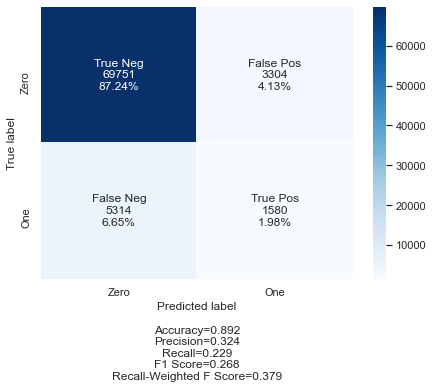

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'XGBoost')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
2,Logistic Regression,0.395,0.350,0.782,0.226,0.750
3,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
0,XGBoost,0.379,0.268,0.229,0.324,0.892
4,Decision Tree,0.370,0.329,0.737,0.212,0.741
5,Decision Tree -- Random Search,0.365,0.323,0.694,0.210,0.749


### Tune XGBoost

In [ ]:
param_grid = {
    'max_depth': [3,4,5,6]
}

Grid Search found the following optimal parameters: 
max_depth: 6


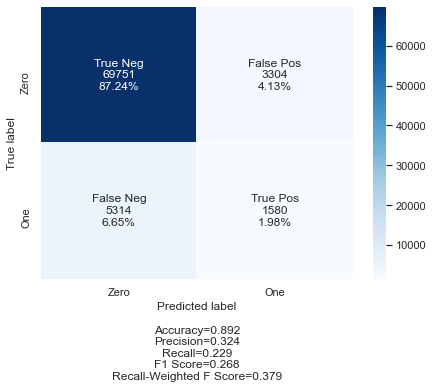

In [ ]:
# Run XGBoost Model
grid_clf = GridSearchCV(clf, param_grid, scoring= class_metric, cv=None, n_jobs=1) 
grid_clf.fit(X_train_resampled, y_train_resampled)
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resampled)
xgboost_gridsearch_pred = grid_clf.predict(X_all_test)

#Plot Confusion Matrix
cf_matrix = confusion_matrix(y_test, xgboost_gridsearch_pred)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')


In [ ]:
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
max_depth: 6


In [ ]:
model_sum = update_results(cf_matrix, 'XGBoost GridSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
2,Logistic Regression,0.395,0.350,0.782,0.226,0.750
3,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
0,XGBoost GridSearch,0.379,0.268,0.229,0.324,0.892
4,XGBoost,0.379,0.268,0.229,0.324,0.892
5,Decision Tree,0.370,0.329,0.737,0.212,0.741
6,Decision Tree -- Random Search,0.365,0.323,0.694,0.210,0.749


## Bagged Trees (Ensemble)

In [ ]:

bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [ ]:
# Fit to the training data
bagged_tree.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [ ]:
bagged_pred = bagged_tree.predict(X_all_test)
cf_matrix = confusion_matrix(y_test, bagged_pred)

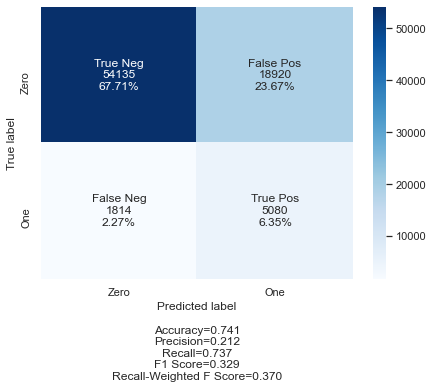

In [ ]:
#  Plot the Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Bagged Tree')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
2,Logistic Regression,0.395,0.350,0.782,0.226,0.750
3,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
4,XGBoost GridSearch,0.379,0.268,0.229,0.324,0.892
5,XGBoost,0.379,0.268,0.229,0.324,0.892
6,Decision Tree,0.370,0.329,0.737,0.212,0.741
0,Bagged Tree,0.370,0.329,0.737,0.212,0.741
7,Decision Tree -- Random Search,0.365,0.323,0.694,0.210,0.749


## Extra Trees

In [ ]:
# fit
ExTrees = ExtraTreesClassifier(n_estimators=100, max_depth= 5)
ExTrees.fit(X_train_resampled, y_train_resampled)

ExtraTreesClassifier(max_depth=5)

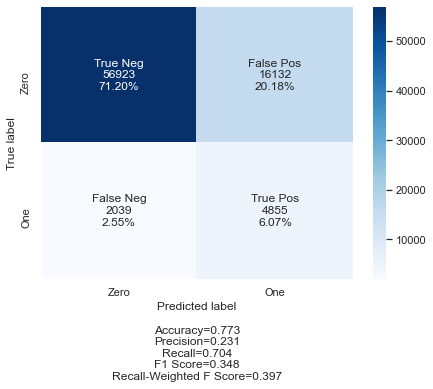

In [ ]:
extrees_pred = ExTrees.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, extrees_pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Extra Trees')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
0,Extra Trees,0.397,0.348,0.704,0.231,0.773
2,Logistic Regression,0.395,0.350,0.782,0.226,0.750
3,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
4,XGBoost GridSearch,0.379,0.268,0.229,0.324,0.892
5,XGBoost,0.379,0.268,0.229,0.324,0.892
6,Decision Tree,0.370,0.329,0.737,0.212,0.741
7,Bagged Tree,0.370,0.329,0.737,0.212,0.741
8,Decision Tree -- Random Search,0.365,0.323,0.694,0.210,0.749


In [ ]:
ExTrees.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Extra Trees with RandomSearchCV

In [ ]:
params = { 'max_depth': [ 3, 4, 5, 6],
           'min_impurity_decrease': np.arange(0.0, 1.0, 0.2),
           'min_samples_leaf': np.arange(1, 5, 1),
           'min_samples_split': np.arange(0,6,1),
           'verbose': np.arange(0,3,1),
           'ccp_alpha': np.arange(0,3,1),
           'bootstrap': [True, False],
           }

ET_clf = RandomizedSearchCV(ExTrees,param_distributions=params,n_jobs= -1, n_iter=50, scoring= class_metric)
ET_clf.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.4s finished


RandomizedSearchCV(estimator=ExtraTreesClassifier(max_depth=5), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': array([0, 1, 2]),
                                        'max_depth': [3, 4, 5, 6],
                                        'min_impurity_decrease': array([0. , 0.2, 0.4, 0.6, 0.8]),
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([0, 1, 2, 3, 4, 5]),
                                        'verbose': array([0, 1, 2])},
                   scoring=make_scorer(my_custom_score))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Grid Search found the following optimal parameters: 
bootstrap: True
ccp_alpha: 0
max_depth: 6
min_impurity_decrease: 0.0
min_samples_leaf: 4
min_samples_split: 2
verbose: 2


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


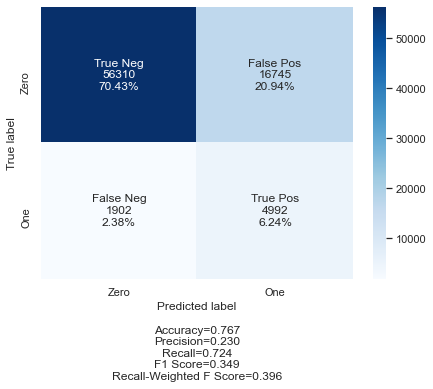

In [ ]:
best_parameters = ET_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

extrees_randsearch_preds = ET_clf.predict(X_all_test)

#Plot Confusion Matrix
cf_matrix = confusion_matrix(y_test, extrees_randsearch_preds)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
cf_matrix = confusion_matrix(y_test, extrees_randsearch_preds)

In [ ]:
model_sum = update_results(cf_matrix, 'Extra Trees -- RandomizedSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
2,Extra Trees,0.397,0.348,0.704,0.231,0.773
0,Extra Trees -- RandomizedSearch,0.396,0.349,0.724,0.230,0.767
3,Logistic Regression,0.395,0.350,0.782,0.226,0.750
4,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
5,XGBoost GridSearch,0.379,0.268,0.229,0.324,0.892
6,XGBoost,0.379,0.268,0.229,0.324,0.892
7,Decision Tree,0.370,0.329,0.737,0.212,0.741
8,Bagged Tree,0.370,0.329,0.737,0.212,0.741


## KNN

In [ ]:
# Running takes 9 minutes
knclf = KNeighborsClassifier()

# Fit 
knclf.fit(X_train_resampled, y_train_resampled)

# Predict
knn_preds = knclf.predict(X_all_test)

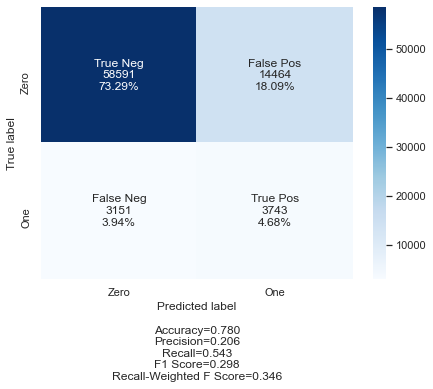

In [ ]:
cf_matrix = confusion_matrix(y_test, knn_preds)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'KNN')
model_sum


,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
2,Extra Trees,0.397,0.348,0.704,0.231,0.773
3,Extra Trees -- RandomizedSearch,0.396,0.349,0.724,0.230,0.767
4,Logistic Regression,0.395,0.350,0.782,0.226,0.750
5,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
6,XGBoost GridSearch,0.379,0.268,0.229,0.324,0.892
7,XGBoost,0.379,0.268,0.229,0.324,0.892
8,Decision Tree,0.370,0.329,0.737,0.212,0.741
9,Bagged Tree,0.370,0.329,0.737,0.212,0.741


In [ ]:
model_sum = model_sum.sort_values('RWF Score', ascending=False)
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
2,Extra Trees,0.397,0.348,0.704,0.231,0.773
3,Extra Trees -- RandomizedSearch,0.396,0.349,0.724,0.230,0.767
4,Logistic Regression,0.395,0.350,0.782,0.226,0.750
5,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
6,XGBoost GridSearch,0.379,0.268,0.229,0.324,0.892
7,XGBoost,0.379,0.268,0.229,0.324,0.892
8,Decision Tree,0.370,0.329,0.737,0.212,0.741
9,Bagged Tree,0.370,0.329,0.737,0.212,0.741


## Results

The best performing models were:
1. Random Trees
2. Extra Trees
3. XGBoost

Because Random Trees has such a strong lead over the others, I will choose to tune the Random Trees model for my final model.

### Final Parameter Tuning

### RandomizedSearchCV with Random Forest

In [ ]:
rs_param = {'criterion' : ['gini', 'entropy'],
          'bootstrap':[True],
          'n_estimators': [50, 100, 150],
          'max_depth': [5, 6, 7, 8],
          'min_samples_leaf': [0, 1,2,3],
          'min_samples_split':[0, 2,4,6,8],
          }

In [ ]:
# 25Min Runtime

r_search = RandomizedSearchCV(forest, n_jobs = -1, n_iter = 35, 
                                param_distributions = rs_param, 
                                scoring= class_metric)
r_search.fit(X_train_resampled, y_train_resampled)
r_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 8,
 'criterion': 'gini',
 'bootstrap': True}

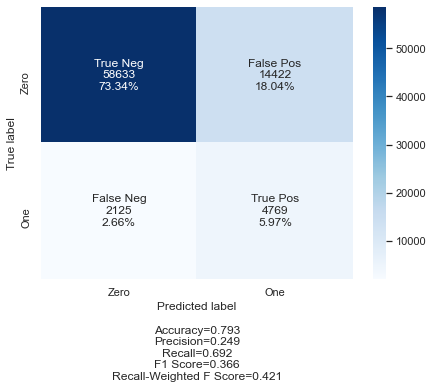

In [ ]:
rf_randsearch_pred = r_search.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, rf_randsearch_pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [ ]:
model_sum = update_results(cf_matrix, 'Random Forest -- RandomizedSearch')
model_sum

,Model,RWF Score,F1,Recall,Precision,Accuracy
0,Random Forest -- RandomizedSearch,0.421,0.366,0.692,0.249,0.793
0,Random Forest -- GridSearch,0.413,0.360,0.713,0.241,0.782
1,Random Forest,0.410,0.359,0.724,0.239,0.777
2,Extra Trees,0.397,0.348,0.704,0.231,0.773
3,Extra Trees -- RandomizedSearch,0.396,0.349,0.724,0.230,0.767
4,Logistic Regression,0.395,0.350,0.782,0.226,0.750
5,Logistic Regression - RandomizedSearch,0.394,0.350,0.782,0.226,0.750
6,XGBoost GridSearch,0.379,0.268,0.229,0.324,0.892
7,XGBoost,0.379,0.268,0.229,0.324,0.892
8,Decision Tree,0.370,0.329,0.737,0.212,0.741


## Grid Search Using Final RandSearch Parameters


In [73]:
grid_srch = {'n_estimators': [50,100,150],
 'min_samples_split': [3,4,5],
 'min_samples_leaf': [1,2],
 'max_depth': [7,8,9],
 'criterion': ['gini'],
 'bootstrap': [True],
 }


In [74]:
r_GridSearch = GridSearchCV(forest, param_grid=grid_srch, cv= 5, scoring= class_metric)

r_GridSearch.fit(X_train_resampled, y_train_resampled)
r_GridSearch.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

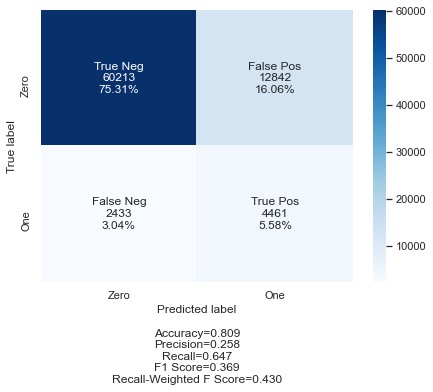

In [75]:
rf_gridsearch_pred = r_GridSearch.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, rf_gridsearch_pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

#### Iteration 1

In [76]:
grid_srch = {'n_estimators': [150,200],
 'min_samples_split': [4],
 'min_samples_leaf': [2,3],
 'max_depth': [9,10],
 'criterion': ['gini'],
 'bootstrap': [True],
 }

In [77]:
r_GridSearch = GridSearchCV(forest, param_grid=grid_srch, cv= 5, scoring= class_metric)

r_GridSearch.fit(X_train_resampled, y_train_resampled)
r_GridSearch.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 150}

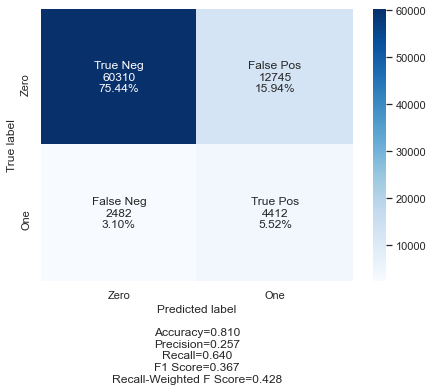

In [78]:
rf_gridsearch_pred = r_GridSearch.predict(X_all_test) 
cf_matrix = confusion_matrix(y_test, rf_gridsearch_pred) 

#plot Confusion Matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## Final Model Interpretation

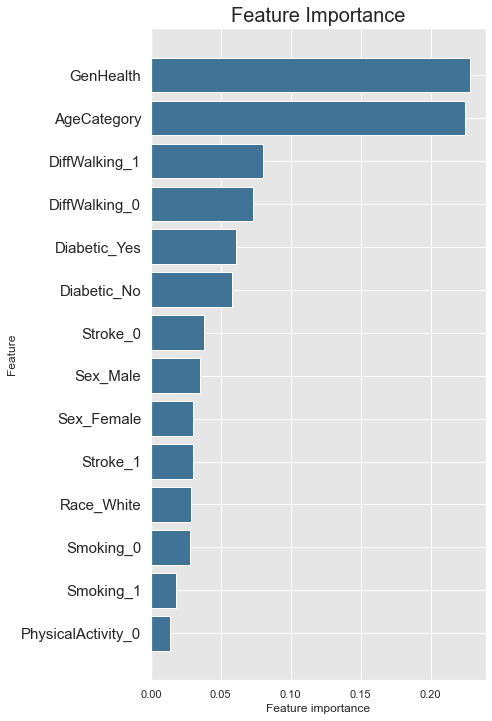

In [79]:
# add importance chart
plot_feature_importances(forest)

### Conclusion

The Final Model is a Random Forest model, optimized by RandomizedSearchCV and GridSearchCV. 

The model's most important features, by far, were Age Category and General Health. 

These two features accounted for .45 of the total feature importance, between the two of them. 

The downsides of this model is it is one of the so-called "black box" models, which we can not read like we could a single decision tree model. This is still a better model, as the performance improvements are worth giving up some understanding of the specifics. 

In the future, I would like a larger set of variables, with more specific questions. While I know that the point of this dataset is to find what general questions can lead to specific results, it would be helpful to have more than 17 variables. It would also be interesting to see this same project done with more specific data, possibly medical data, to see what variables we need to achieve higher scores all around. 
